In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import scipy.signal as signal

In [2]:
def extract_weightmap(im):
    "selects the non white part of the image"
    ww = np.zeros(shape=im.shape[:2])
    ww[np.where(im.sum(axis=2) < 4.)] = 1.
    return ww

def invert_weightmap(ww):
    return 1 - ww

# Loading maps

In [3]:
map_oceans = plt.imread("../maps/LOTR_MAPS_oceans.png")
map_rivers = plt.imread("../maps/LOTR_MAPS_rivers.png")
map_hills = plt.imread("../maps/LOTR_MAPS_hills.png")
map_mountains = plt.imread("../maps/LOTR_MAPS_mountains.png")
map_ridges = plt.imread("../maps/LOTR_MAPS_ridges.png")

In [4]:
wmap_oceans = extract_weightmap(map_oceans)
wmap_rivers = extract_weightmap(map_rivers)
wmap_hills = extract_weightmap(map_hills)
wmap_mountains = extract_weightmap(map_mountains)
wmap_ridges = extract_weightmap(map_ridges)

In [5]:
wmap_land = invert_weightmap(wmap_oceans)

# Constructing height map

In [6]:
np.random.seed(5)

In [7]:
sh = wmap_land.shape
num = sh[0] * sh[1]
values = np.random.uniform(size=num)

In [8]:
canvas = np.zeros(shape = wmap_land.shape)
canvas = values.reshape(canvas.shape)

In [9]:
ridge_heights = 5000
mountain_heights = 2000
hill_heights = 500
land_heights = 100

In [16]:
raw_canvas = np.zeros(shape = wmap_land.shape)
raw_canvas = np.random.uniform(size=num).reshape(raw_canvas.shape)
canvas = raw_canvas * wmap_land
canvas = ((raw_canvas * wmap_land * land_heights) +
         (raw_canvas * wmap_hills * hill_heights) +
         (raw_canvas * wmap_mountains * mountain_heights) +
         (raw_canvas * wmap_ridges * ridge_heights)) 

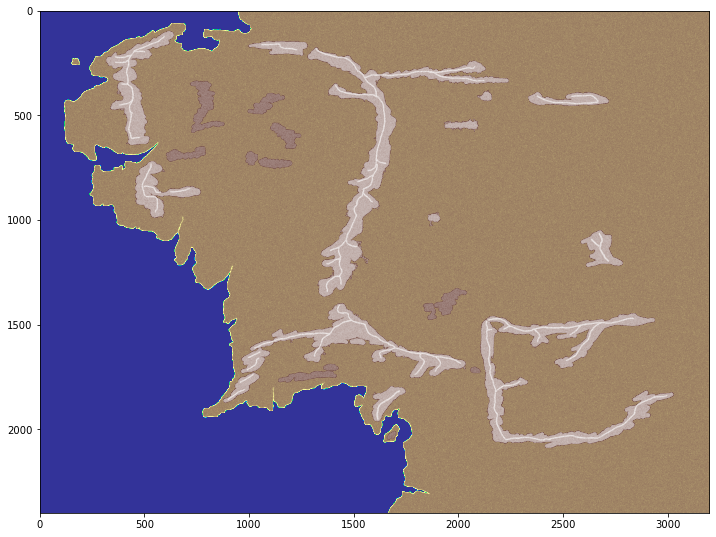

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(canvas + 0.001, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())

# Preparing smoothing and correlation

In [18]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel
    

In [60]:
kernels = {
    "gauss": gaussian,
    "tophat": tophat,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp
    

In [63]:
res = make_noise_map(100, raw_canvas.shape)

Text(0.5, 1.0, 'wavelength 100')

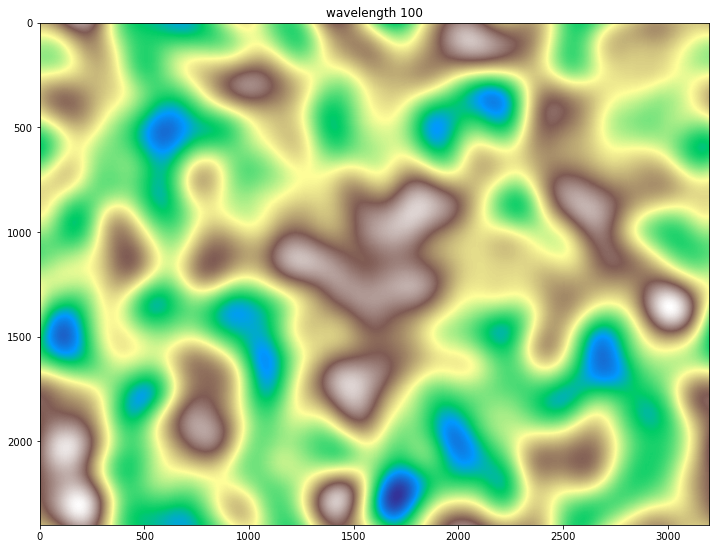

In [65]:

res = make_noise_map(100, raw_canvas.shape)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(res, cmap=plt.cm.terrain)
ax.set_title("wavelength 100")

Text(0.5, 1.0, 'wavelength 20')

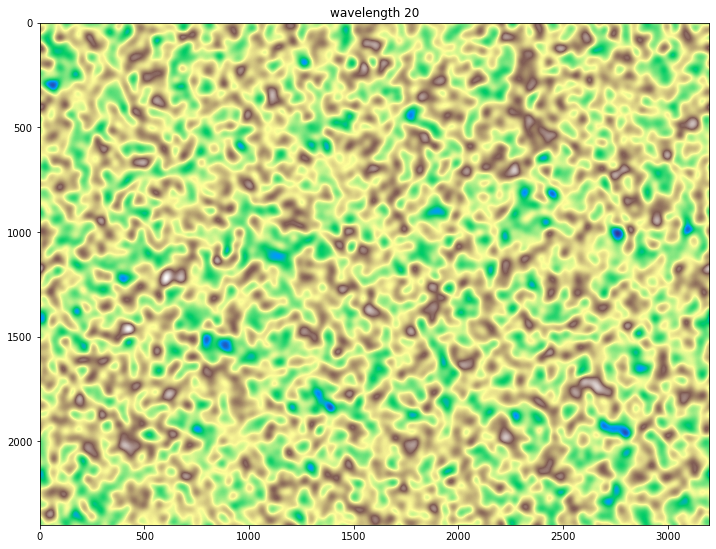

In [67]:

res = make_noise_map(20, raw_canvas.shape)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(res, cmap=plt.cm.terrain)
ax.set_title("wavelength 20")

# Creating a layered height map

In [68]:
np.random.seed(5)

In [85]:
ridge_heights = 5000
mountain_heights = 2000
hill_heights = 500
land_heights = 100

land_scale = 200
hill_scale = 100
mountain_scale = 10
ridge_scale = 5

heights = [land_heights, hill_heights, mountain_heights, ridge_heights]
scales = [land_scale, hill_scale, mountain_scale, ridge_scale]
wmaps = [wmap_land, wmap_hills, wmap_mountains, wmap_ridges]

In [89]:
raw_canvas = np.zeros(shape = wmap_land.shape)
canvas = raw_canvas.copy() + 30

for i, (height, scale) in enumerate(zip(heights, scales)):
    print(height, scale)
    canvas += wmaps[i] * make_noise_map(scale, canvas.shape) * height
#canvas += wmap_land * make_noise_map(200, canvas.shape) * land_heights
#canvas += wmap_land * make_noise_map(200, canvas.shape) * land_heights

100 200
500 100
2000 10
5000 5


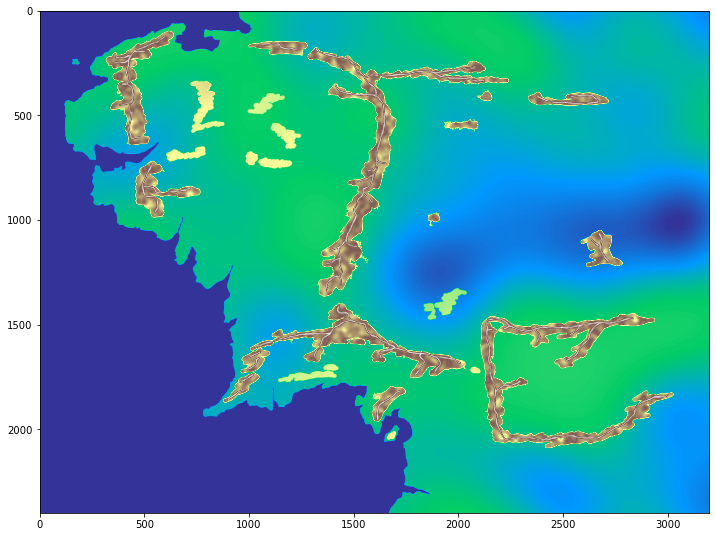

In [90]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(canvas, cmap=plt.cm.terrain)
ax.imshow(canvas + 0.001, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())

In [ ]:
canvas + wmap_land * canvas = raw_canvas * wmap_land



In [ ]:
raw_canvas = np.zeros(shape = wmap_land.shape)
raw_canvas = np.random.uniform(size=num).reshape(raw_canvas.shape)
canvas = raw_canvas * wmap_land
canvas = ((raw_canvas * wmap_land * land_heights) +
         (raw_canvas * wmap_hills * hill_heights) +
         (raw_canvas * wmap_mountains * mountain_heights) +
         (raw_canvas * wmap_ridges * ridge_heights)) 

In [79]:
dists = distance_kernel(half_extent=100)
top50 = gaussian(dists, scale=40)
top20 = gaussian(dists, scale=20)
top10 = gaussian(dists, scale=10)

In [80]:
z50 = np.fft.irfft2(np.fft.rfft2(canvas) * np.fft.rfft2(top50, canvas.shape))
z20 = np.fft.irfft2(np.fft.rfft2(canvas) * np.fft.rfft2(top20, canvas.shape))
z10 = np.fft.irfft2(np.fft.rfft2(canvas) * np.fft.rfft2(top10, canvas.shape))

In [81]:
z = z50 + z20 + z10

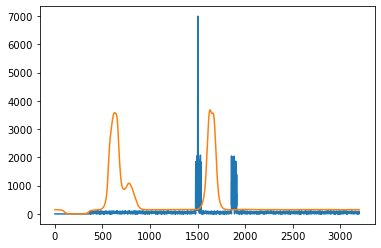

In [82]:
plt.plot(canvas[1000, :])
plt.plot(z[1000, :])

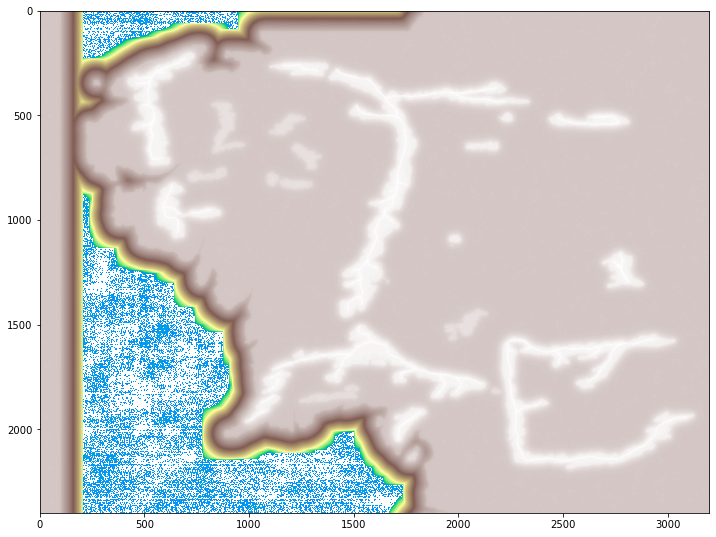

In [78]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(z, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())